In [16]:
import json 

models = [
    "Phind-CodeLlama-34B-v2",
    "gpt-3.5-turbo-1106",
    "WizardCoder-15B-V1.0",
    "gpt-4-0125-preview",
    "deepseek-coder-6.7b-instruct",
]

todo_maps = {
    pa: {
        "complexity": json.load(open(f"./statistics/complexity_{pa}.json")),
        "files": [json.loads(line)["target"] for line in open(f"../data/dataset/stripped-context/data-{pa}.jsonl")],
    }
    for pa in ["PA19", "PA20", "PA21", "PA22"]
}

In [17]:
import re 
import pandas as pd
import tiktoken
from collections import Counter

def num_tokens_from_str(content):
    encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(content))

# Java关键字列表
java_keywords = [
    'abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'const',
    'continue', 'default', 'do', 'double', 'else', 'enum', 'extends', 'final', 'finally', 'float',
    'for', 'if', 'goto', 'implements', 'import', 'instanceof', 'int', 'interface', 'long',
    'native', 'new', 'package', 'private', 'protected', 'public', 'return', 'short', 'static',
    'strictfp', 'super', 'switch', 'synchronized', 'this', 'throw', 'throws', 'transient', 'try',
    'void', 'volatile', 'while', 'true', 'false', 'null'
]

# 正则表达式模式，用于匹配Java关键字
keyword_pattern = r'\b(' + '|'.join(java_keywords) + r')\b'

def count_java_keywords(pa, file_path):
    with open(f"../projects/{pa}-Solution/src/main/java/{file_path}") as f:
        code = f.read()

    keywords_found = re.findall(keyword_pattern, code)
    keyword_count = Counter(keywords_found)
    return keyword_count

def get_complexity(pa, file_path):
    components = todo_maps[pa]["complexity"]["components"]
    comp = next((comp for comp in components if comp["key"].endswith(file_path)), None)
    return int(comp["measures"][0]["value"]), int(comp["measures"][1]["value"])

def get_prompt_token_count(pa, file_path):
    path = f"../data/dataset/stripped-context/data-{pa}.jsonl"

    with open(path) as f:
        for line in f:
            data = json.loads(line)
            if file_path.endswith(data["target"]):
                return num_tokens_from_str(data["code"]) + num_tokens_from_str(data["code_context"])

def get_model_data(pa, file_path, models):
    def hit(file_path, task_id):
        split = "/" + task_id.split("/")[-1]
        return file_path.endswith(split)

    data = {}
    for model in models:
        path = f"../data/class/result-{pa}/{model}/single_class.json"

        raw_result = filter(lambda item: hit(file_path, item["task_id"]), json.load(open(path)))

        lazy_proportion_counter = [0, 0]
        pass_at_one_counter = [0, 0]
        for record in raw_result:
            if record["has_todo"] and record["compile_errors"] == 0:
                lazy_proportion_counter[0] += 1
            lazy_proportion_counter[1] += 1
            
            if record["compile_errors"] == 0 and record["can_replace"] and not record["has_todo"]:
                pass_at_one_counter[0] += 1
            pass_at_one_counter[1] += 1
        data[model] = {
            "lazy_proportion": lazy_proportion_counter[0] / lazy_proportion_counter[1],
            "pass_at_one": pass_at_one_counter[0] / pass_at_one_counter[1],
        }
    return data

data = {
    "PA": [],
    "File": [],
    "Keywords": [],
    "Complexity": [],
    "Cognitive Complexity": [],
    "Prompt Token Count": [],
    # Model Lazy Proportion
}

for pa in todo_maps:
    for file in todo_maps[pa]["files"]:
        complexity, cognitive_complexity = get_complexity(pa, file)
        data['PA'].append(pa)
        data["File"].append(file)
        data['Keywords'].append(sum(count_java_keywords(pa, file).values()))
        data['Complexity'].append(complexity)
        data['Cognitive Complexity'].append(cognitive_complexity)
        data['Prompt Token Count'].append(get_prompt_token_count(pa, file))

        results = get_model_data(pa, file, models)
        for model in models:
            lazy_proportion = f"Lazy {model}"
            if data.get(lazy_proportion) is None:
                data[lazy_proportion] = []
            data[lazy_proportion].append(results[model]["lazy_proportion"])

        # for model in models:
        #     pass_at_one = f"Pass@1 {model}"
        #     if data.get(pass_at_one) is None:
        #         data[pass_at_one] = []
        #     data[pass_at_one].append(results[model]["pass_at_one"])

for k, v in data.items():
    print(f"{k}: {len(v)}")

df = pd.DataFrame(data)
df.to_csv("./statistics.csv", index=False)
df

PA: 45
File: 45
Keywords: 45
Complexity: 45
Cognitive Complexity: 45
Prompt Token Count: 45
Lazy Phind-CodeLlama-34B-v2: 45
Lazy gpt-3.5-turbo-1106: 45
Lazy WizardCoder-15B-V1.0: 45
Lazy gpt-4-0125-preview: 45
Lazy deepseek-coder-6.7b-instruct: 45


,PA,File,Keywords,Complexity,Cognitive Complexity,Prompt Token Count,Lazy Phind-CodeLlama-34B-v2,Lazy gpt-3.5-turbo-1106,Lazy WizardCoder-15B-V1.0,Lazy gpt-4-0125-preview,Lazy deepseek-coder-6.7b-instruct
0,PA19,game/map/cells/Cell.java,55,12,9,720,0.00,0.00,0.00,0.0,0.00
1,PA19,game/map/cells/FillableCell.java,31,5,1,736,0.00,0.00,0.00,0.0,0.00
2,PA19,game/map/cells/TerminationCell.java,60,13,6,834,0.00,0.00,0.00,0.0,0.00
3,PA19,game/map/cells/Wall.java,12,2,0,630,0.00,0.00,0.00,0.0,0.00
4,PA19,game/map/Map.java,271,93,164,2411,0.00,0.00,0.00,0.0,0.00
5,PA19,game/pipes/Pipe.java,100,23,3,1022,0.30,0.00,0.00,0.0,0.10
6,PA19,game/CellStack.java,24,5,1,332,0.00,0.00,0.00,0.0,0.00
7,PA19,game/DelayBar.java,20,5,2,336,0.00,0.00,0.00,1.0,0.00
8,PA19,game/Game.java,103,16,7,2074,0.00,0.00,0.00,0.0,0.00
9,PA19,game/PipeQueue.java,46,13,6,816,0.00,0.00,0.00,0.0,0.00


mse: 0.3285


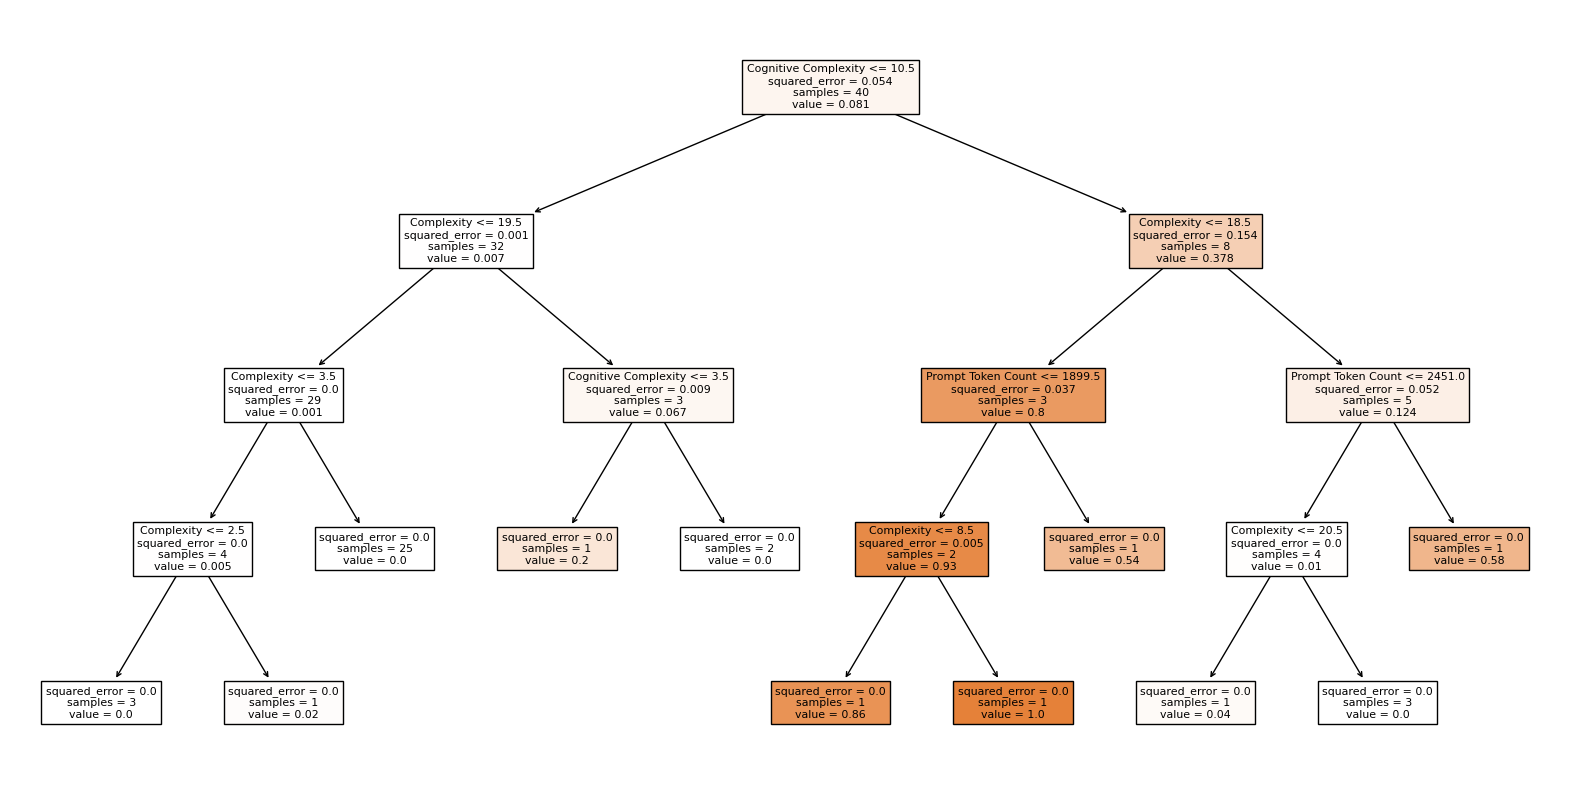

In [47]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error

targets = df.filter(regex="^(Lazy|Pass@1)")
X = df[df.columns.difference(targets.columns)].drop(["PA", "File"], axis=1)
Y = df["Lazy Phind-CodeLlama-34B-v2"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
clf = DecisionTreeRegressor(max_depth=10)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f"mse: {mse}")

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True)
plt.show()